In [33]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import tqdm as tqdm

Files already downloaded and verified
Files already downloaded and verified


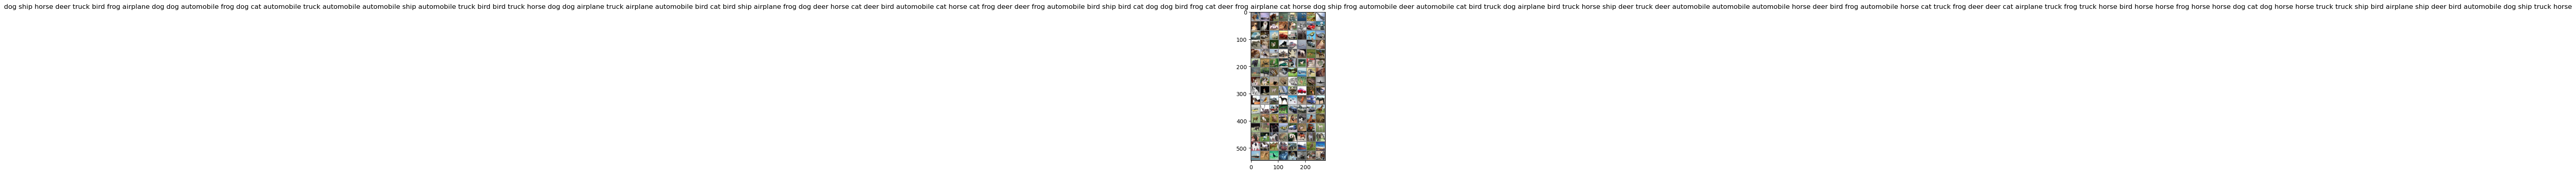

In [35]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize( (0.5, 0.5, 0.5), (0.5, 0.5, 0.5) )])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform = transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size = 128, shuffle = True)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform = transform)
testloader = torch.utils.data.DataLoader(testset, batch_size = 128, shuffle = True)

images, labels = next(iter(trainloader))
plt.imshow(torchvision.utils.make_grid(images).permute(1,2,0) / 2 + 0.5)
plt.title(' '.join(trainset.classes[label] for label in labels));
plt.show()
test_losses = []

In [37]:
class CIFAR10_NN(nn.Module):
    def __init__(self, activation_name):
        super(CIFAR10_NN, self).__init__()
        self.fcLayer1 = nn.Linear(32*32*3, 512)
        self.fcLayer2 = nn.Linear(512, 256)
        self.fcLayer3 = nn.Linear(256, 16)
        # self.fcLayer4 = nn.Linear(128, 64)
        # self.fcLayer5 = nn.Linear(64, 32)
        # self.fcLayer6 = nn.Linear(32, 16)
        self.fcLayer7 = nn.Linear(16, 10)
        if activation_name == "sigmoid": 
            self.activation = nn.Sigmoid()
        elif activation_name == "relu":
            self.activation = nn.ReLU()
        else:
            self.activation = nn.Tanh()
    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = self.activation(self.fcLayer1(x))
        x = self.activation(self.fcLayer2(x))
        x = self.activation(self.fcLayer3(x))
        # x = self.activation(self.fcLayer4(x))
        # x = self.activation(self.fcLayer5(x))
        # x = self.activation(self.fcLayer6(x))
        x = self.fcLayer7(x)
        return x

In [39]:
def train_and_test(activation):
    device = torch.device("cpu")
    model = CIFAR10_NN(activation).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr = 0.001)

    epochs = 10
    train_losses = []
    test_losses = []
    for epoch in range(epochs):
        running_loss = 0.0
        train_acc=0.0
        with tqdm.tqdm(total=len(trainloader)) as pbar:
            for batch_idx, (images, labels) in enumerate(trainloader):
                images, labels = images.to(device), labels.to(device)
                optimizer.zero_grad()
                outputs = model(images)
                loss=criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                last_loss = loss.item()
                acc = torch.sum(torch.argmax(outputs, dim=1) == labels)
                train_acc += acc
                # Only print gradients for the last batch of the epoch
                pbar.set_postfix(Loss='{0:.4f}'.format(loss.item()), Accuracy='{0:.4f}'.format(float(train_acc.item()/(images.size(0)*(batch_idx+1)))))
                pbar.update(1)
                if batch_idx == len(trainloader) - 1:
                    print(f"Epoch {epoch+1}/{epochs}, Loss: {last_loss:.4f}")
                    check_gradients(model)
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for images, labels in testloader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                test_loss += loss.item()
        test_losses.append(test_loss / len(testloader))
        average_loss = running_loss / len(trainloader)
        train_losses.append(average_loss)
        print(f"{epoch + 1} / {epochs}, activation = {activation}, loss = {average_loss: .4f}")
    return train_losses, test_losses

In [41]:
def check_gradients(model):
    for name, param in model.named_parameters():
        if param.grad is not None:
            print(f"{name} Gradient Norm: {param.grad.norm().item()}")

In [43]:
activation_fns = ["sigmoid", "tanh", "relu"]
results = {}
for activation in activation_fns:
    results[activation] = (train_and_test(activation))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 95.43it/s, Accuracy=0.4220, Loss=1.9883]


Epoch 1/10, Loss: 1.9883
fcLayer1.weight Gradient Norm: 0.085348941385746
fcLayer1.bias Gradient Norm: 0.00235080742277205
fcLayer2.weight Gradient Norm: 0.05603941157460213
fcLayer2.bias Gradient Norm: 0.0030990804079920053
fcLayer3.weight Gradient Norm: 0.08523667603731155
fcLayer3.bias Gradient Norm: 0.007841987535357475
fcLayer7.weight Gradient Norm: 0.14162354171276093
fcLayer7.bias Gradient Norm: 0.050569791346788406
1 / 10, activation = sigmoid, loss =  2.0107


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 96.02it/s, Accuracy=0.5897, Loss=1.7667]


Epoch 2/10, Loss: 1.7667
fcLayer1.weight Gradient Norm: 0.11276217550039291
fcLayer1.bias Gradient Norm: 0.003627588041126728
fcLayer2.weight Gradient Norm: 0.07656919211149216
fcLayer2.bias Gradient Norm: 0.004713038913905621
fcLayer3.weight Gradient Norm: 0.11992795020341873
fcLayer3.bias Gradient Norm: 0.013148468919098377
fcLayer7.weight Gradient Norm: 0.23759984970092773
fcLayer7.bias Gradient Norm: 0.08806882798671722
2 / 10, activation = sigmoid, loss =  1.7953


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 97.67it/s, Accuracy=0.6627, Loss=1.6153]


Epoch 3/10, Loss: 1.6153
fcLayer1.weight Gradient Norm: 0.18139435350894928
fcLayer1.bias Gradient Norm: 0.005928353872150183
fcLayer2.weight Gradient Norm: 0.17026810348033905
fcLayer2.bias Gradient Norm: 0.01155576016753912
fcLayer3.weight Gradient Norm: 0.22882835566997528
fcLayer3.bias Gradient Norm: 0.026457933709025383
fcLayer7.weight Gradient Norm: 0.17056256532669067
fcLayer7.bias Gradient Norm: 0.0613609217107296
3 / 10, activation = sigmoid, loss =  1.6643


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 89.81it/s, Accuracy=0.7157, Loss=1.4793]


Epoch 4/10, Loss: 1.4793
fcLayer1.weight Gradient Norm: 0.1881583333015442
fcLayer1.bias Gradient Norm: 0.006697922013700008
fcLayer2.weight Gradient Norm: 0.16316848993301392
fcLayer2.bias Gradient Norm: 0.010846070945262909
fcLayer3.weight Gradient Norm: 0.17932428419589996
fcLayer3.bias Gradient Norm: 0.019275691360235214
fcLayer7.weight Gradient Norm: 0.23585250973701477
fcLayer7.bias Gradient Norm: 0.08713198453187943
4 / 10, activation = sigmoid, loss =  1.5631


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 96.08it/s, Accuracy=0.7650, Loss=1.3473]


Epoch 5/10, Loss: 1.3473
fcLayer1.weight Gradient Norm: 0.2520076334476471
fcLayer1.bias Gradient Norm: 0.009113205596804619
fcLayer2.weight Gradient Norm: 0.21561627089977264
fcLayer2.bias Gradient Norm: 0.014523597434163094
fcLayer3.weight Gradient Norm: 0.24036388099193573
fcLayer3.bias Gradient Norm: 0.02836734615266323
fcLayer7.weight Gradient Norm: 0.2675853967666626
fcLayer7.bias Gradient Norm: 0.10081949830055237
5 / 10, activation = sigmoid, loss =  1.4753


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 90.19it/s, Accuracy=0.8021, Loss=1.4435]


Epoch 6/10, Loss: 1.4435
fcLayer1.weight Gradient Norm: 0.3349040746688843
fcLayer1.bias Gradient Norm: 0.01236516609787941
fcLayer2.weight Gradient Norm: 0.29692456126213074
fcLayer2.bias Gradient Norm: 0.02116805501282215
fcLayer3.weight Gradient Norm: 0.311868816614151
fcLayer3.bias Gradient Norm: 0.035784993320703506
fcLayer7.weight Gradient Norm: 0.2736259698867798
fcLayer7.bias Gradient Norm: 0.099805548787117
6 / 10, activation = sigmoid, loss =  1.4086


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:12<00:00, 31.26it/s, Accuracy=0.8399, Loss=1.4314]


Epoch 7/10, Loss: 1.4314
fcLayer1.weight Gradient Norm: 0.35191795229911804
fcLayer1.bias Gradient Norm: 0.012113193981349468
fcLayer2.weight Gradient Norm: 0.2578319311141968
fcLayer2.bias Gradient Norm: 0.016431182622909546
fcLayer3.weight Gradient Norm: 0.2648523449897766
fcLayer3.bias Gradient Norm: 0.029422316700220108
fcLayer7.weight Gradient Norm: 0.2009018063545227
fcLayer7.bias Gradient Norm: 0.06469763070344925
7 / 10, activation = sigmoid, loss =  1.3391


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 97.29it/s, Accuracy=0.8771, Loss=1.2720]


Epoch 8/10, Loss: 1.2720
fcLayer1.weight Gradient Norm: 0.3605436682701111
fcLayer1.bias Gradient Norm: 0.012619460001587868
fcLayer2.weight Gradient Norm: 0.269309937953949
fcLayer2.bias Gradient Norm: 0.016977546736598015
fcLayer3.weight Gradient Norm: 0.26400139927864075
fcLayer3.bias Gradient Norm: 0.03012963943183422
fcLayer7.weight Gradient Norm: 0.22457611560821533
fcLayer7.bias Gradient Norm: 0.08482260257005692
8 / 10, activation = sigmoid, loss =  1.2786


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [06:04<00:00,  1.07it/s, Accuracy=0.9129, Loss=1.1881]


Epoch 9/10, Loss: 1.1881
fcLayer1.weight Gradient Norm: 0.36033394932746887
fcLayer1.bias Gradient Norm: 0.014707975089550018
fcLayer2.weight Gradient Norm: 0.3738858997821808
fcLayer2.bias Gradient Norm: 0.02864300273358822
fcLayer3.weight Gradient Norm: 0.40561142563819885
fcLayer3.bias Gradient Norm: 0.049955859780311584
fcLayer7.weight Gradient Norm: 0.29110458493232727
fcLayer7.bias Gradient Norm: 0.11583393067121506
9 / 10, activation = sigmoid, loss =  1.2175


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [03:41<00:00,  1.76it/s, Accuracy=0.9528, Loss=1.3205]


Epoch 10/10, Loss: 1.3205
fcLayer1.weight Gradient Norm: 0.45833244919776917
fcLayer1.bias Gradient Norm: 0.019698379561305046
fcLayer2.weight Gradient Norm: 0.4401457905769348
fcLayer2.bias Gradient Norm: 0.03220872953534126
fcLayer3.weight Gradient Norm: 0.5001043081283569
fcLayer3.bias Gradient Norm: 0.06333265453577042
fcLayer7.weight Gradient Norm: 0.31090670824050903
fcLayer7.bias Gradient Norm: 0.12565220892429352
10 / 10, activation = sigmoid, loss =  1.1536


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 96.65it/s, Accuracy=0.5687, Loss=1.7978]


Epoch 1/10, Loss: 1.7978
fcLayer1.weight Gradient Norm: 0.3173641860485077
fcLayer1.bias Gradient Norm: 0.015436721965670586
fcLayer2.weight Gradient Norm: 0.3547303080558777
fcLayer2.bias Gradient Norm: 0.021539514884352684
fcLayer3.weight Gradient Norm: 0.5217865705490112
fcLayer3.bias Gradient Norm: 0.049671538174152374
fcLayer7.weight Gradient Norm: 0.3555898368358612
fcLayer7.bias Gradient Norm: 0.1452392041683197
1 / 10, activation = tanh, loss =  1.8387


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [08:53<00:00,  1.36s/it, Accuracy=0.6712, Loss=1.5510]


Epoch 2/10, Loss: 1.5510
fcLayer1.weight Gradient Norm: 0.378357470035553
fcLayer1.bias Gradient Norm: 0.014372380450367928
fcLayer2.weight Gradient Norm: 0.48858442902565
fcLayer2.bias Gradient Norm: 0.020452549681067467
fcLayer3.weight Gradient Norm: 0.6904626488685608
fcLayer3.bias Gradient Norm: 0.051182691007852554
fcLayer7.weight Gradient Norm: 0.3123598098754883
fcLayer7.bias Gradient Norm: 0.1289633959531784
2 / 10, activation = tanh, loss =  1.6680


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [06:31<00:00,  1.00s/it, Accuracy=0.7115, Loss=1.5657]


Epoch 3/10, Loss: 1.5657
fcLayer1.weight Gradient Norm: 0.501284122467041
fcLayer1.bias Gradient Norm: 0.014529252424836159
fcLayer2.weight Gradient Norm: 0.6196397542953491
fcLayer2.bias Gradient Norm: 0.023287486284971237
fcLayer3.weight Gradient Norm: 0.8195821046829224
fcLayer3.bias Gradient Norm: 0.05507612228393555
fcLayer7.weight Gradient Norm: 0.34420788288116455
fcLayer7.bias Gradient Norm: 0.09261418133974075
3 / 10, activation = tanh, loss =  1.5883


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 95.95it/s, Accuracy=0.7490, Loss=1.5572]


Epoch 4/10, Loss: 1.5572
fcLayer1.weight Gradient Norm: 0.4633938670158386
fcLayer1.bias Gradient Norm: 0.018495896831154823
fcLayer2.weight Gradient Norm: 0.5856528282165527
fcLayer2.bias Gradient Norm: 0.03178038075566292
fcLayer3.weight Gradient Norm: 0.9589232206344604
fcLayer3.bias Gradient Norm: 0.09002328664064407
fcLayer7.weight Gradient Norm: 0.31599152088165283
fcLayer7.bias Gradient Norm: 0.12426457554101944
4 / 10, activation = tanh, loss =  1.5244


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [02:35<00:00,  2.52it/s, Accuracy=0.7806, Loss=1.4978]


Epoch 5/10, Loss: 1.4978
fcLayer1.weight Gradient Norm: 0.5351539850234985
fcLayer1.bias Gradient Norm: 0.019921885803341866
fcLayer2.weight Gradient Norm: 0.7060562968254089
fcLayer2.bias Gradient Norm: 0.028660302981734276
fcLayer3.weight Gradient Norm: 0.9227111339569092
fcLayer3.bias Gradient Norm: 0.042066361755132675
fcLayer7.weight Gradient Norm: 0.24031709134578705
fcLayer7.bias Gradient Norm: 0.062117889523506165
5 / 10, activation = tanh, loss =  1.4688


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [04:43<00:00,  1.38it/s, Accuracy=0.8117, Loss=1.3282]


Epoch 6/10, Loss: 1.3282
fcLayer1.weight Gradient Norm: 0.6130427122116089
fcLayer1.bias Gradient Norm: 0.02139611355960369
fcLayer2.weight Gradient Norm: 0.7136905789375305
fcLayer2.bias Gradient Norm: 0.03844001889228821
fcLayer3.weight Gradient Norm: 0.943419873714447
fcLayer3.bias Gradient Norm: 0.08346986770629883
fcLayer7.weight Gradient Norm: 0.24969163537025452
fcLayer7.bias Gradient Norm: 0.10165354609489441
6 / 10, activation = tanh, loss =  1.4201


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 96.09it/s, Accuracy=0.8354, Loss=1.3086]


Epoch 7/10, Loss: 1.3086
fcLayer1.weight Gradient Norm: 0.6092373132705688
fcLayer1.bias Gradient Norm: 0.021022943779826164
fcLayer2.weight Gradient Norm: 0.8464738726615906
fcLayer2.bias Gradient Norm: 0.03648049384355545
fcLayer3.weight Gradient Norm: 1.1750234365463257
fcLayer3.bias Gradient Norm: 0.07070128619670868
fcLayer7.weight Gradient Norm: 0.2715068459510803
fcLayer7.bias Gradient Norm: 0.08918637037277222
7 / 10, activation = tanh, loss =  1.3699


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [01:27<00:00,  4.48it/s, Accuracy=0.8559, Loss=1.6418]


Epoch 8/10, Loss: 1.6418
fcLayer1.weight Gradient Norm: 0.6449196934700012
fcLayer1.bias Gradient Norm: 0.023171262815594673
fcLayer2.weight Gradient Norm: 0.9058476090431213
fcLayer2.bias Gradient Norm: 0.03770877420902252
fcLayer3.weight Gradient Norm: 1.0976006984710693
fcLayer3.bias Gradient Norm: 0.05337989330291748
fcLayer7.weight Gradient Norm: 0.2649952173233032
fcLayer7.bias Gradient Norm: 0.08158376812934875
8 / 10, activation = tanh, loss =  1.3267


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [03:30<00:00,  1.86it/s, Accuracy=0.8848, Loss=1.2410]


Epoch 9/10, Loss: 1.2410
fcLayer1.weight Gradient Norm: 0.5879310369491577
fcLayer1.bias Gradient Norm: 0.02105845883488655
fcLayer2.weight Gradient Norm: 0.8396908640861511
fcLayer2.bias Gradient Norm: 0.035170961171388626
fcLayer3.weight Gradient Norm: 1.1962205171585083
fcLayer3.bias Gradient Norm: 0.07275541871786118
fcLayer7.weight Gradient Norm: 0.28062066435813904
fcLayer7.bias Gradient Norm: 0.10316906124353409
9 / 10, activation = tanh, loss =  1.2844


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 94.94it/s, Accuracy=0.9081, Loss=1.3044]


Epoch 10/10, Loss: 1.3044
fcLayer1.weight Gradient Norm: 0.6621553301811218
fcLayer1.bias Gradient Norm: 0.02635064534842968
fcLayer2.weight Gradient Norm: 0.9228917956352234
fcLayer2.bias Gradient Norm: 0.04198465123772621
fcLayer3.weight Gradient Norm: 1.219702124595642
fcLayer3.bias Gradient Norm: 0.08051984757184982
fcLayer7.weight Gradient Norm: 0.2162248194217682
fcLayer7.bias Gradient Norm: 0.07098958641290665
10 / 10, activation = tanh, loss =  1.2407


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [05:46<00:00,  1.13it/s, Accuracy=0.6318, Loss=1.4899]


Epoch 1/10, Loss: 1.4899
fcLayer1.weight Gradient Norm: 0.33719849586486816
fcLayer1.bias Gradient Norm: 0.01074107177555561
fcLayer2.weight Gradient Norm: 0.652395486831665
fcLayer2.bias Gradient Norm: 0.011171216145157814
fcLayer3.weight Gradient Norm: 1.2325493097305298
fcLayer3.bias Gradient Norm: 0.02530089020729065
fcLayer7.weight Gradient Norm: 1.2089641094207764
fcLayer7.bias Gradient Norm: 0.08460795879364014
1 / 10, activation = relu, loss =  1.7076


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [14:52<00:00,  2.28s/it, Accuracy=0.7872, Loss=1.3152]


Epoch 2/10, Loss: 1.3152
fcLayer1.weight Gradient Norm: 0.38207897543907166
fcLayer1.bias Gradient Norm: 0.015749899670481682
fcLayer2.weight Gradient Norm: 0.7922275066375732
fcLayer2.bias Gradient Norm: 0.013820892199873924
fcLayer3.weight Gradient Norm: 1.4287199974060059
fcLayer3.bias Gradient Norm: 0.0309905968606472
fcLayer7.weight Gradient Norm: 1.248884916305542
fcLayer7.bias Gradient Norm: 0.07051849365234375
2 / 10, activation = relu, loss =  1.4349


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 90.88it/s, Accuracy=0.8582, Loss=1.2466]


Epoch 3/10, Loss: 1.2466
fcLayer1.weight Gradient Norm: 0.4067895710468292
fcLayer1.bias Gradient Norm: 0.018582649528980255
fcLayer2.weight Gradient Norm: 0.8882395029067993
fcLayer2.bias Gradient Norm: 0.015291732735931873
fcLayer3.weight Gradient Norm: 1.8106491565704346
fcLayer3.bias Gradient Norm: 0.048890337347984314
fcLayer7.weight Gradient Norm: 1.7758923768997192
fcLayer7.bias Gradient Norm: 0.09782739728689194
3 / 10, activation = relu, loss =  1.3128


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [07:29<00:00,  1.15s/it, Accuracy=0.9113, Loss=1.1711]


Epoch 4/10, Loss: 1.1711
fcLayer1.weight Gradient Norm: 0.4103635251522064
fcLayer1.bias Gradient Norm: 0.014520950615406036
fcLayer2.weight Gradient Norm: 0.8638231754302979
fcLayer2.bias Gradient Norm: 0.010816565714776516
fcLayer3.weight Gradient Norm: 1.3355348110198975
fcLayer3.bias Gradient Norm: 0.02722136117517948
fcLayer7.weight Gradient Norm: 1.1671524047851562
fcLayer7.bias Gradient Norm: 0.06622646749019623
4 / 10, activation = relu, loss =  1.2188


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 97.03it/s, Accuracy=0.9610, Loss=1.2189]


Epoch 5/10, Loss: 1.2189
fcLayer1.weight Gradient Norm: 0.5176591277122498
fcLayer1.bias Gradient Norm: 0.020053574815392494
fcLayer2.weight Gradient Norm: 1.1218647956848145
fcLayer2.bias Gradient Norm: 0.017971588298678398
fcLayer3.weight Gradient Norm: 2.1538102626800537
fcLayer3.bias Gradient Norm: 0.053604986518621445
fcLayer7.weight Gradient Norm: 2.384957790374756
fcLayer7.bias Gradient Norm: 0.11334525793790817
5 / 10, activation = relu, loss =  1.1306


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 91.76it/s, Accuracy=1.0064, Loss=1.3407]


Epoch 6/10, Loss: 1.3407
fcLayer1.weight Gradient Norm: 0.5508460402488708
fcLayer1.bias Gradient Norm: 0.0212143212556839
fcLayer2.weight Gradient Norm: 1.2604774236679077
fcLayer2.bias Gradient Norm: 0.016864316537976265
fcLayer3.weight Gradient Norm: 2.1271493434906006
fcLayer3.bias Gradient Norm: 0.05106426030397415
fcLayer7.weight Gradient Norm: 2.3138692378997803
fcLayer7.bias Gradient Norm: 0.10755635797977448
6 / 10, activation = relu, loss =  1.0527


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 88.94it/s, Accuracy=1.0454, Loss=1.0706]


Epoch 7/10, Loss: 1.0706
fcLayer1.weight Gradient Norm: 0.5585522651672363
fcLayer1.bias Gradient Norm: 0.019311226904392242
fcLayer2.weight Gradient Norm: 1.1983301639556885
fcLayer2.bias Gradient Norm: 0.012422222644090652
fcLayer3.weight Gradient Norm: 1.7892929315567017
fcLayer3.bias Gradient Norm: 0.030318763107061386
fcLayer7.weight Gradient Norm: 1.8526129722595215
fcLayer7.bias Gradient Norm: 0.06936744600534439
7 / 10, activation = relu, loss =  0.9750


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 89.54it/s, Accuracy=1.0850, Loss=1.0956]


Epoch 8/10, Loss: 1.0956
fcLayer1.weight Gradient Norm: 0.6295281052589417
fcLayer1.bias Gradient Norm: 0.02164953388273716
fcLayer2.weight Gradient Norm: 1.3897188901901245
fcLayer2.bias Gradient Norm: 0.016299059614539146
fcLayer3.weight Gradient Norm: 1.826566457748413
fcLayer3.bias Gradient Norm: 0.03320295363664627
fcLayer7.weight Gradient Norm: 1.806156873703003
fcLayer7.bias Gradient Norm: 0.07302990555763245
8 / 10, activation = relu, loss =  0.9018


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [11:57<00:00,  1.83s/it, Accuracy=1.1348, Loss=0.9208]


Epoch 9/10, Loss: 0.9208
fcLayer1.weight Gradient Norm: 0.7052066326141357
fcLayer1.bias Gradient Norm: 0.022614607587456703
fcLayer2.weight Gradient Norm: 1.446857213973999
fcLayer2.bias Gradient Norm: 0.01335455384105444
fcLayer3.weight Gradient Norm: 1.879332184791565
fcLayer3.bias Gradient Norm: 0.02698543108999729
fcLayer7.weight Gradient Norm: 2.3457767963409424
fcLayer7.bias Gradient Norm: 0.0751916691660881
9 / 10, activation = relu, loss =  0.8216


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 391/391 [00:04<00:00, 97.02it/s, Accuracy=1.1637, Loss=0.9083]


Epoch 10/10, Loss: 0.9083
fcLayer1.weight Gradient Norm: 0.6808599233627319
fcLayer1.bias Gradient Norm: 0.029709504917263985
fcLayer2.weight Gradient Norm: 1.4134447574615479
fcLayer2.bias Gradient Norm: 0.019744526594877243
fcLayer3.weight Gradient Norm: 1.6578720808029175
fcLayer3.bias Gradient Norm: 0.04321108013391495
fcLayer7.weight Gradient Norm: 2.027020215988159
fcLayer7.bias Gradient Norm: 0.08340900391340256
10 / 10, activation = relu, loss =  0.7610


[2.010658649227503, 1.7953341138332397, 1.6643396420856875, 1.5630767467381703, 1.475306810625374, 1.4085730631333178, 1.3391350135778832, 1.2786433702844489, 1.217497110824146, 1.1536191633290342] [1.869076443623893, 1.7258265063732485, 1.6329745039155212, 1.552734461011766, 1.5097671415232405, 1.500956719434714, 1.4636713070205496, 1.4680306504044351, 1.4683858126024656, 1.5047862258138536]


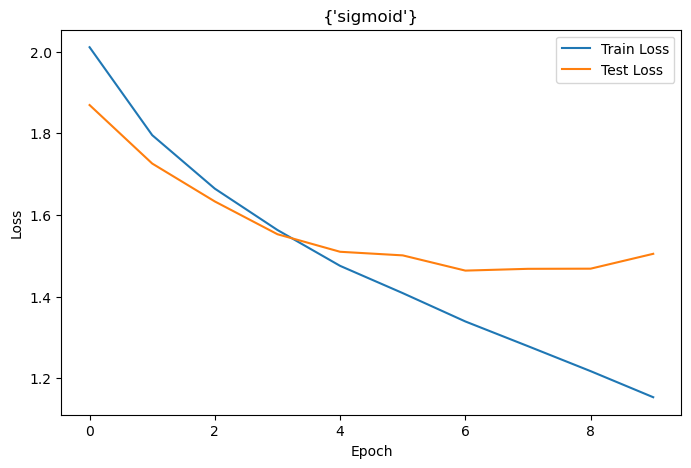

[1.8386828999994966, 1.6680193663862966, 1.5882900249012901, 1.5244390083395916, 1.4688131470814385, 1.4200910552383383, 1.3698615415017013, 1.3267267997307546, 1.28437262300945, 1.2406729717388787] [1.7240090219280388, 1.6746651356733298, 1.607673003703733, 1.565387626237507, 1.5556656273105476, 1.5311351109154616, 1.5482017993927002, 1.5191520226152637, 1.5250648169577876, 1.5174902104124237]


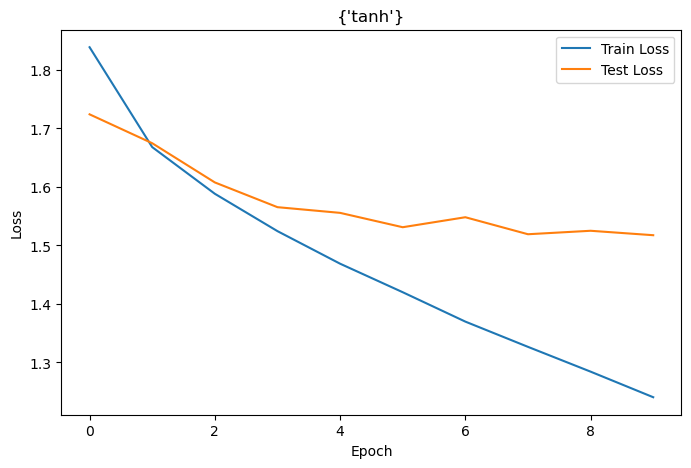

[1.7076344587613859, 1.4348962520394484, 1.312807820337203, 1.2188152141888122, 1.1305712932515937, 1.0526960313777485, 0.9749739775267403, 0.9017823501621061, 0.821642439688563, 0.7609975848661359] [1.5255996984771536, 1.4247213224821453, 1.3587688267985476, 1.3419663227057155, 1.3263980572736715, 1.3429352709009676, 1.3461488062822367, 1.4046903426134134, 1.4298408604875397, 1.496458519863177]


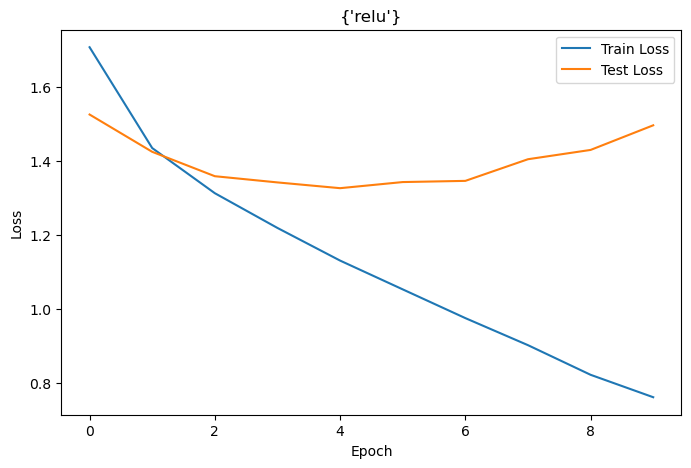

In [45]:
for name, result in results.items():
    print(result[0], result[1])
    plt.figure(figsize=(8, 5))
    plt.plot(result[0], label = 'Train Loss')
    plt.plot(result[1], label = 'Test Loss')
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title({name})
    plt.legend()
    plt.show()